# Run lunar lander - Q learning

### Author: lyds 
***

Here we train our `ActionBot` using a basic Q learning approach using lookups to a `QTable`

In [1]:
import sys
sys.path.append("..")

In [2]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from src.episode_memory import LanderMemory
from src.action_bot import QActionBot

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark

%watermark -u -n -t
%watermark -iv -v

last updated: Mon Jan 27 2020 10:00:51
matplotlib 3.0.3
gym        0.12.0
numpy      1.16.2
CPython 3.6.8
IPython 7.2.0


### Set up training parameters
***

In [5]:
env_name = "LunarLander-v2"
total_episodes = 1000
max_time_steps = 500
env_seed = None

load = False
save = False
rendering = False
replay = False

### Instantiate objects
***


In [6]:
if total_episodes < 1:
    raise ValueError("Cannot have number of episodes less than 1")

env = gym.make(env_name)
best_memory = LanderMemory()
best_memory.total_reward = -np.inf

reward_vals = []
reward_window = deque(maxlen=100)

action_bot = QActionBot(env)
if load:
    action_bot.load_q_table('../fitted_models/q_table_vx_vy.p')

### Train
***

We train using a Q-learning approach. 

We take an action according to an epsilon-greedy policy. We take the action with the greatest Q value across actions for a given state provided that:
> $r$ < $\max(\frac{1}{\sqrt{n + 1}}, 0.01)$

Having been rewarded (or not) we update the Q value according to:
> $Q_{new}(s_t, a_t)$ = 1 - $\alpha$ . $Q_(s_t, a_t)$ + $\alpha$ . ($r_t$ + $\gamma$ . $\max(Q_(s_{t+1}, a_t))$)

Rolling average reward for episode:100 = -193.33848380235668
Rolling average reward for episode:200 = -158.45024477461124
Rolling average reward for episode:300 = -119.93215344373455
Rolling average reward for episode:400 = -142.16740003918164
Rolling average reward for episode:500 = -131.88415333340924
Rolling average reward for episode:600 = -146.22926579078958
Rolling average reward for episode:700 = -154.43642972440222
Rolling average reward for episode:800 = -143.45903700012965
Rolling average reward for episode:900 = -157.6572998911854
Highest total reward = 254.06177559756406
Average total reward = -150.94248151965238


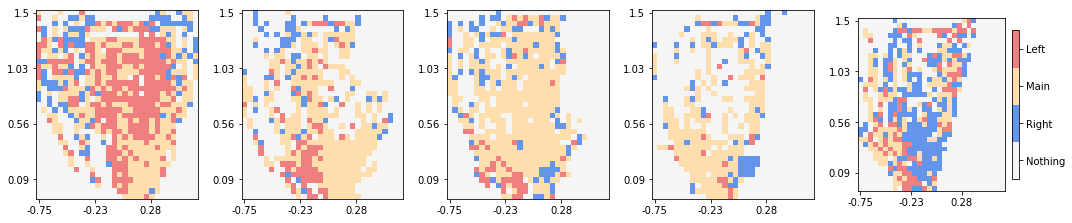

Wall time: 53.6 s


In [7]:
%%time
for episode_number in range(total_episodes):
    
    # record memorues
    episode_memory = LanderMemory()
    if env_seed is not None:
        episode_memory.seed = env_seed
    env.seed(episode_memory.seed)
    
    # set up episode run
    obs = env.reset()
    done = False
    t = 0

    while not done and t <= max_time_steps:
        if rendering:
            env.render()
        
        # get action
        action_bot.obs = obs
        action_bot.episode_n = episode_number
        action = action_bot.get_q_action()
        
        # update action bot
        new_obs, reward, done, _ = env.step(action)        
        action_bot.update_q_table(new_obs, action, reward)
        episode_memory.update(action, reward)
        obs = new_obs
        t += 1

    env.close()

    if episode_number % 100 == 0 and episode_number > 0:
        print(
            "Rolling average reward for episode:{} = {}".format(
                episode_number, np.mean(reward_window)
            )
        )

    if episode_number % 500 == 0 and save:
        action_bot.save_q_table()

    reward_vals.append(episode_memory.total_reward)
    reward_window.append(episode_memory.total_reward)

    if best_memory.total_reward < episode_memory.total_reward:
        best_memory = episode_memory

print("Highest total reward = {}".format(best_memory.total_reward))
print("Average total reward = {}".format(sum(reward_vals) / total_episodes))

if save:
    action_bot.save_q_table()
    
action_bot.plot_q_table()

Plot the training history with a rolling mean

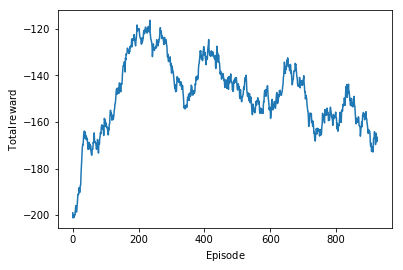

In [8]:
N = 75
plt.plot(np.convolve(reward_vals, np.ones((N,))/N, mode='valid'))
plt.xlabel(r"$\mathrm{Episode}$")
plt.ylabel(r"$\mathrm{Total \/ reward}$")
plt.show()

Show the best episode that we experienced

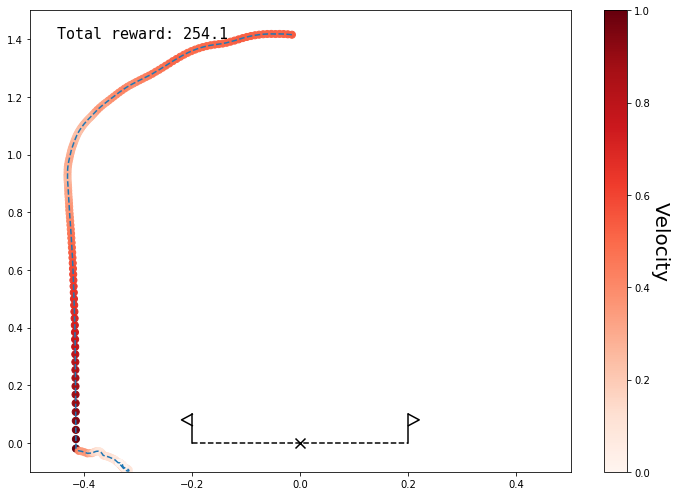

In [9]:
best_memory.replay(True, True)

***
Alternatively view the output of a previously trained model.

The one shown has converged to a reasonable state that you might expect i.e. fire the engine to get you towards the centre, if you're near the centre then slow yourself down!

Loaded Q table from ../fitted_models/q_table.p
Q table has shape: (30, 35, 5, 10, 4)


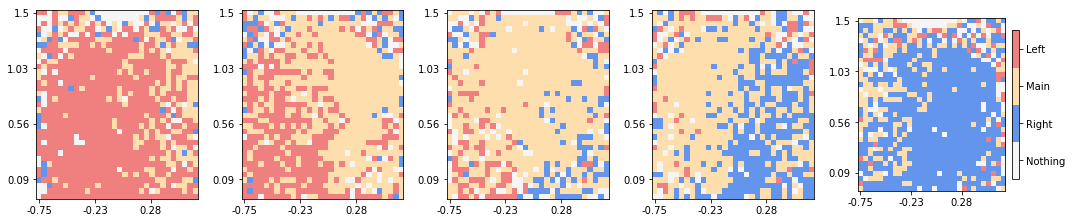

In [10]:
def plot_q_table(filename):
    env = gym.make("LunarLander-v2")
    action_bot = QActionBot(env)
    action_bot.load_q_table(filename)
    action_bot.plot_q_table()

plot_q_table("../fitted_models/q_table.p")

### Demo the model
***
Load in a model with fitted weights and run an episode

Loaded Q table from ../fitted_models/q_table_vx_vy.p
Q table has shape: (30, 35, 5, 10, 10, 2, 4)


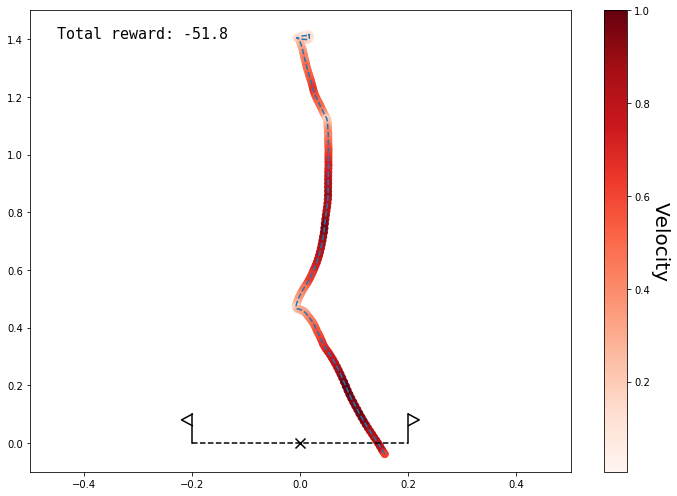

Total reward for memory: -51.84


In [11]:
action_bot = QActionBot(env)
action_bot.load_q_table('../fitted_models/q_table_vx_vy.p')
action_bot.demo = True

# set up episode run
episode_memory = LanderMemory()
if env_seed is not None:
    episode_memory.seed = env_seed
env.seed(episode_memory.seed)
obs = env.reset()
done = False
t = 0

while not done and t <= max_time_steps:
    # get action
    action_bot.obs = obs
    action_bot.episode_n = 1
    action = action_bot.get_q_action()
    # update action bot
    new_obs, reward, done, _ = env.step(action)        
    episode_memory.update(action, reward)
    obs = new_obs
    t += 1
    
episode_memory.replay(True, True)
print(f"Total reward for memory: {episode_memory.total_reward:.2f}")